## Analisis de Datos de Pinguinos

Mediciones de tamaño, observaciones de nidadas y proporciones de isótopos en la sangre de pingüinos Adelie, Chinstrap y Gentoo adultos en busca de alimento observados en islas del archipiélago Palmer cerca de la estación Palmer, en la Antártida. Los datos fueron recopilados y puestos a disposición por la Dra. Kristen Gorman y el Programa de Investigación Ecológica a Largo Plazo (LTER) de la Estación Palmer.

In [93]:
import empiricaldist
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
import statsmodels.formula.api as smf
import statsmodels.stats as ss

### Apariencia de los Graficos

In [117]:
#almacena los graficos en el notebooks
%matplotlib inline 
sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (10, 8)

In [111]:
#Paleta de colores
penguin_color = {
    'Adelie': '#ff6602ff',
    'Gentoo': '#0f7175ff',
    'Chinstrap': '#c65dc9ff'
}

### 1. Cargar los Datos

In [95]:
preprocess_penguins_df = pd.read_csv('./data/penguins.csv')
preprocess_penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


### 2. Recoleccion y Validacion de los Datos

In [96]:
# Tipos de datos del dataset
preprocess_penguins_df.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
year                   int64
dtype: object

Tenemos 4 variables de tipo float, 3 de tipo object y 1 de tipo int

In [97]:
# Cantidad de variables de cada tipo
(
    preprocess_penguins_df
    .dtypes
    .value_counts()
)

float64    4
object     3
int64      1
dtype: int64

In [98]:
# Cantidad de registros en el dataset
preprocess_penguins_df.shape

(344, 8)

In [99]:
# Variables que contienen valores nulos
(
    preprocess_penguins_df
    .isna()
    .any()
)

species              False
island               False
bill_length_mm        True
bill_depth_mm         True
flipper_length_mm     True
body_mass_g           True
sex                   True
year                 False
dtype: bool

In [100]:
# Cantidad de valores nulos por variable
(
    preprocess_penguins_df
    .isnull()
    .sum()
)

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [101]:
# Total de valores nulos en el dataset
(
    preprocess_penguins_df
    .isnull()
    .sum()
    .sum()
)

19

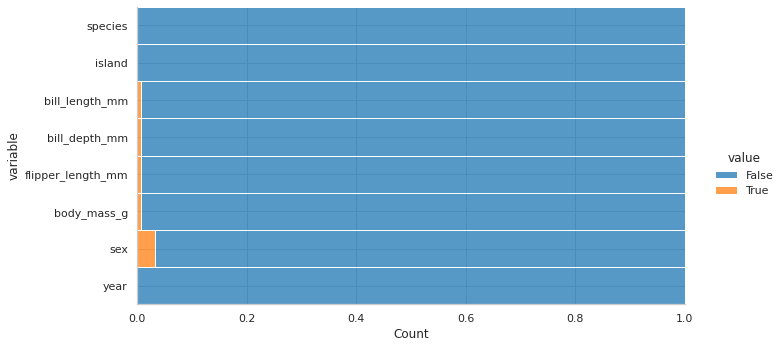

In [102]:
# Visualizacion de Proporcion de Valores nulos por cada variable
(
    preprocess_penguins_df
    .isnull()
    .melt()  # Convierte un df de formato ancho a formato largo
    .pipe(   # permite aplicar una o mas funciones al objeto df 
        lambda df:(
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2 #ancho del grafica
            )
        )
    )
)
plt.show()

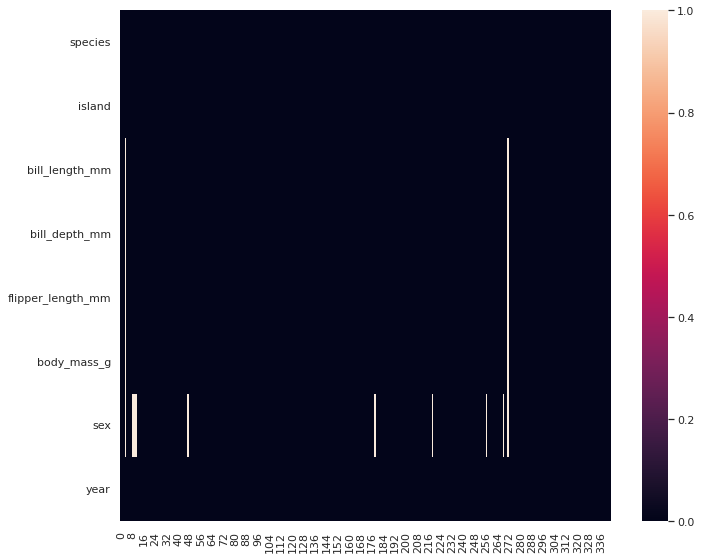

In [103]:
# Visualizacion de los valores nulos en todo el conjunto de datos
(
    preprocess_penguins_df
    .isnull()
    .transpose()
    .pipe(
        lambda df:(
            sns.heatmap(  #mapa de calor
                data=df
            )
        )
    )
)

plt.show()

In [104]:
# Cantidad de observaciones que se pierden si se eliminan los datos faltantes
preprocess_penguins_df = (
    preprocess_penguins_df
    .dropna()
)
preprocess_penguins_df.shape

(333, 8)

Se pierden 21 observaviones. No es una cantidad relevante que pueda influir en el analisis

### 3. Conteos y Proporciones

In [105]:
# Resumen estadistico de las variables numericas
preprocess_penguins_df.describe(include=[np.number])

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,2008.042042
std,5.468668,1.969235,14.015765,805.215802,0.812944
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.500000,15.600000,190.000000,3550.000000,2007.000000
50%,44.500000,17.300000,197.000000,4050.000000,2008.000000
75%,48.600000,18.700000,213.000000,4775.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


In [106]:
# Resumen estadistico de las variables categoricas
preprocess_penguins_df.describe(include=object)

,species,island,sex
count,333,333,333
unique,3,3,2
top,Adelie,Biscoe,male
freq,146,163,168


In [107]:
# Convertir las variables de tipo object en category
(
    preprocess_penguins_df
    .astype({
        'species':'category',
        'island':'category',
        'sex':'category'
    })
)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


### 3.1 Visualizacion de los Conteos

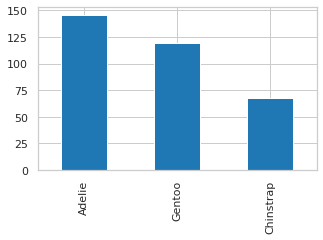

In [108]:
# Utilizando Pandas
# histograma de las Especies
(
    preprocess_penguins_df
    .species
    .value_counts()
    .plot(
        kind='bar',
        figsize=(5,3)
    )

)
plt.show()

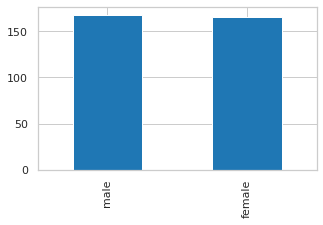

In [109]:
# Histograma del Sexo de los pinguinos
(
    preprocess_penguins_df
    .sex
    .value_counts()
    .plot(
        kind='bar',
        figsize=(5,3)
    )

)
plt.show()

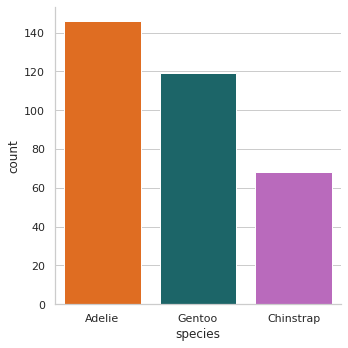

In [120]:
# Utilizando Seaborn
# histograma segun las Especies
sns.catplot(
    data=preprocess_penguins_df,
    x= 'species',
    kind= 'count',
    palette= penguin_color
)
plt.show()

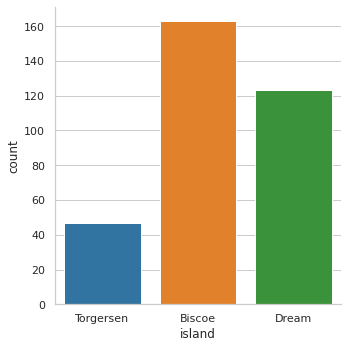

In [122]:
# Histograma de la cantidad de pinguinos segun la isla
sns.catplot(
    data=preprocess_penguins_df,
    x= 'island',
    kind= 'count',
    #palette= penguin_color
)
plt.show()

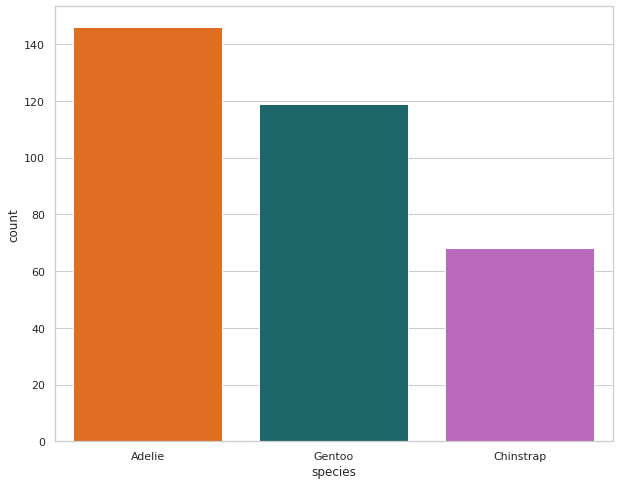

In [124]:
# Creando un Histograma directamente desde una tabla. Especies
(
    preprocess_penguins_df
    .value_counts('species', sort=True)
    .reset_index(name='count')
    .pipe(
        lambda df:(
            sns.barplot(
                data=df,
                x='species',
                y='count',
                palette=penguin_color
            )
        )
    )
)
plt.show()

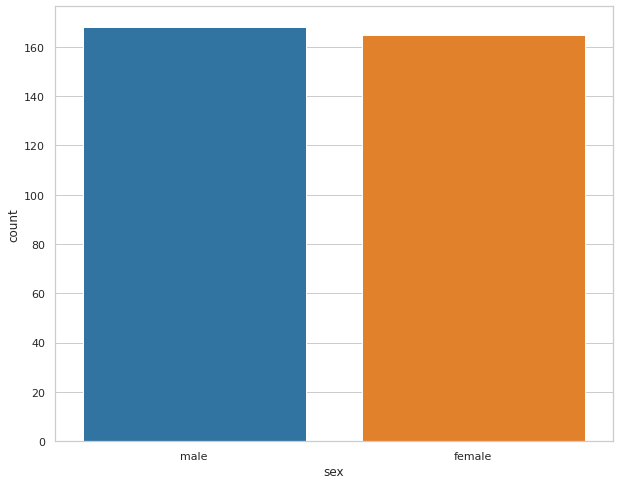

In [125]:
# Creando un Histograma directamente desde una tabla. Sexo

(
    preprocess_penguins_df
    .value_counts('sex', sort=True)
    .reset_index(name='count')
    .pipe(
        lambda df:(
            sns.barplot(
                data=df,
                x='sex',
                y='count',
                #palette=penguin_color
            )
        )
    )
)
plt.show()